In [1]:

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
# load dataset
dataset = read_csv('SP500Data.csv',index_col=0)

In [3]:
type(dataset)

pandas.core.frame.DataFrame

In [4]:
# shape
dataset.shape

(448, 502)

In [5]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.88,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.28,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998


In [6]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(448, 502)

In [7]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(448, 498)

In [8]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

/tmp/ipykernel_9814/565654842.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset=dataset.fillna(method='ffill')


,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998


In [9]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [10]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [11]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

In [12]:
returns

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.002211,0.015649,0.017300,0.004615,0.015550,0.018796,0.051913,0.009049,-0.000919,-0.004531,...,0.018709,-0.010834,-0.006693,-0.001362,0.020035,0.012193,-0.000858,0.006932,-0.001183,0.004598
2018-01-04,-0.001697,-0.005703,0.017516,0.011841,-0.009952,0.012042,0.049351,0.036899,-0.003680,-0.017712,...,0.010151,0.005415,-0.007791,0.012274,0.018053,0.006676,0.010180,-0.001441,0.004147,0.005964
2018-01-05,0.002890,0.017408,0.015408,0.008249,0.026446,0.011571,-0.019802,0.010631,0.003693,0.004684,...,0.006413,0.006671,-0.007003,0.007410,0.051922,-0.001874,0.005828,0.009941,0.000393,0.011444
2018-01-08,-0.002882,-0.016022,0.027086,0.007991,0.003917,-0.001619,0.033670,-0.007042,0.000000,0.005314,...,-0.005387,-0.013314,0.007480,0.011702,0.006608,0.003611,0.001690,0.001905,-0.004914,0.011996
2018-01-09,0.001700,0.007538,0.009432,0.003335,-0.006604,0.008971,-0.037459,-0.008080,-0.010120,-0.001297,...,0.002774,0.006778,-0.011667,-0.002313,0.002679,0.000288,-0.002651,-0.016083,0.023509,0.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-30,0.011233,-0.005765,0.023121,0.006813,-0.009775,0.004133,-0.002136,0.023174,-0.010585,-0.013300,...,0.011384,-0.025876,0.002797,0.000317,0.017366,0.002163,0.019067,0.005970,-0.014571,0.011666
2019-05-31,-0.005097,-0.011596,-0.016780,-0.004194,-0.004362,-0.013151,-0.022119,-0.027543,-0.005664,-0.026028,...,-0.012325,-0.036794,-0.000349,-0.030101,-0.029777,0.001214,0.007878,0.009213,-0.020246,-0.012509
2019-06-03,-0.005517,-0.013166,-0.001871,-0.016342,-0.022827,-0.043817,0.006202,-0.011806,0.008228,0.007039,...,0.014587,-0.035032,0.010638,0.012088,-0.000098,0.020210,0.017196,0.003248,0.005805,0.028699


In [13]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [14]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

/tmp/ipykernel_9814/893448057.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist, 'ward')


array([24.        , 25.        ,  0.09110116,  2.        ])

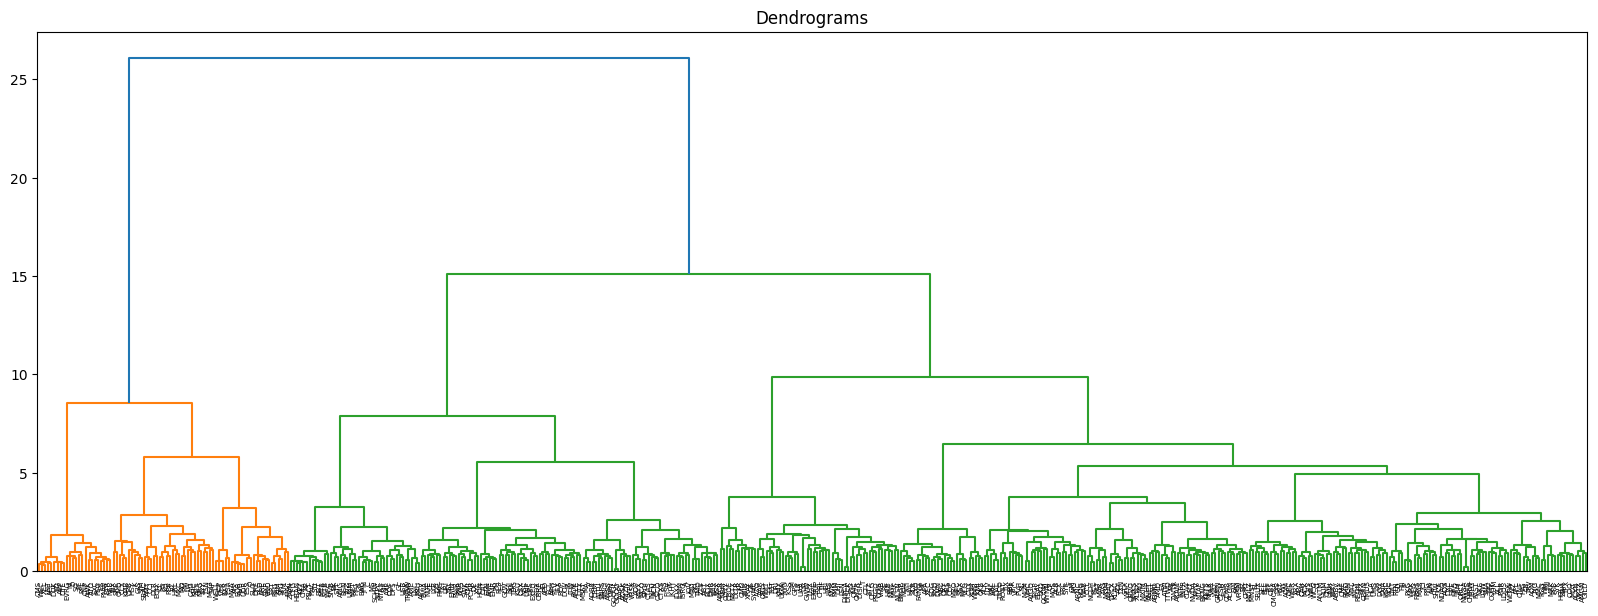

In [15]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")
dendrogram(link,labels = X.columns)
plt.show()

<a id='4.2'></a>
## Steps for Hierarchial Risk Parity
#### Quasi-diagonalization and getting the weights for Hierarchial Risk Parity


A 'quasi-diagonalization' is a process usually known as matrix seriation and which can be performed using hierarchical clustering.
This process reorganize the covariance matrix so similar investments will be placed together. This matrix diagonalization allow us to distribute weights optimally following an inverse-variance allocation.

In [16]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0])  # use concat instead of append
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive bisection
 This step distributes the allocation through recursive bisection based on cluster covariance.

In [17]:
def getIVP(cov, **kargs):
# Compute the inverse-variance portfolio
     ivp = 1. / np.diag(cov)
     ivp /= ivp.sum()
     return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison against other asset allocation methods:.

The main premise of this case study
was to develop an alternative to Markowitz’s Minimum-Variance Portfolio based
asset allocation. So, in this step, we define a functions to compare the performance of the following asset allocation methods.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [19]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Step 4:  Getting the portfolio weights for all types of asset allocation

In [20]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [21]:
portfolios = get_all_portfolios(returns)

/tmp/ipykernel_9814/886878674.py:44: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, 'single')
/tmp/ipykernel_9814/3577539578.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378 0.59353378
 0.59353378 0.59353378 0.5935337

Text(0.5, 1.0, 'HRP')

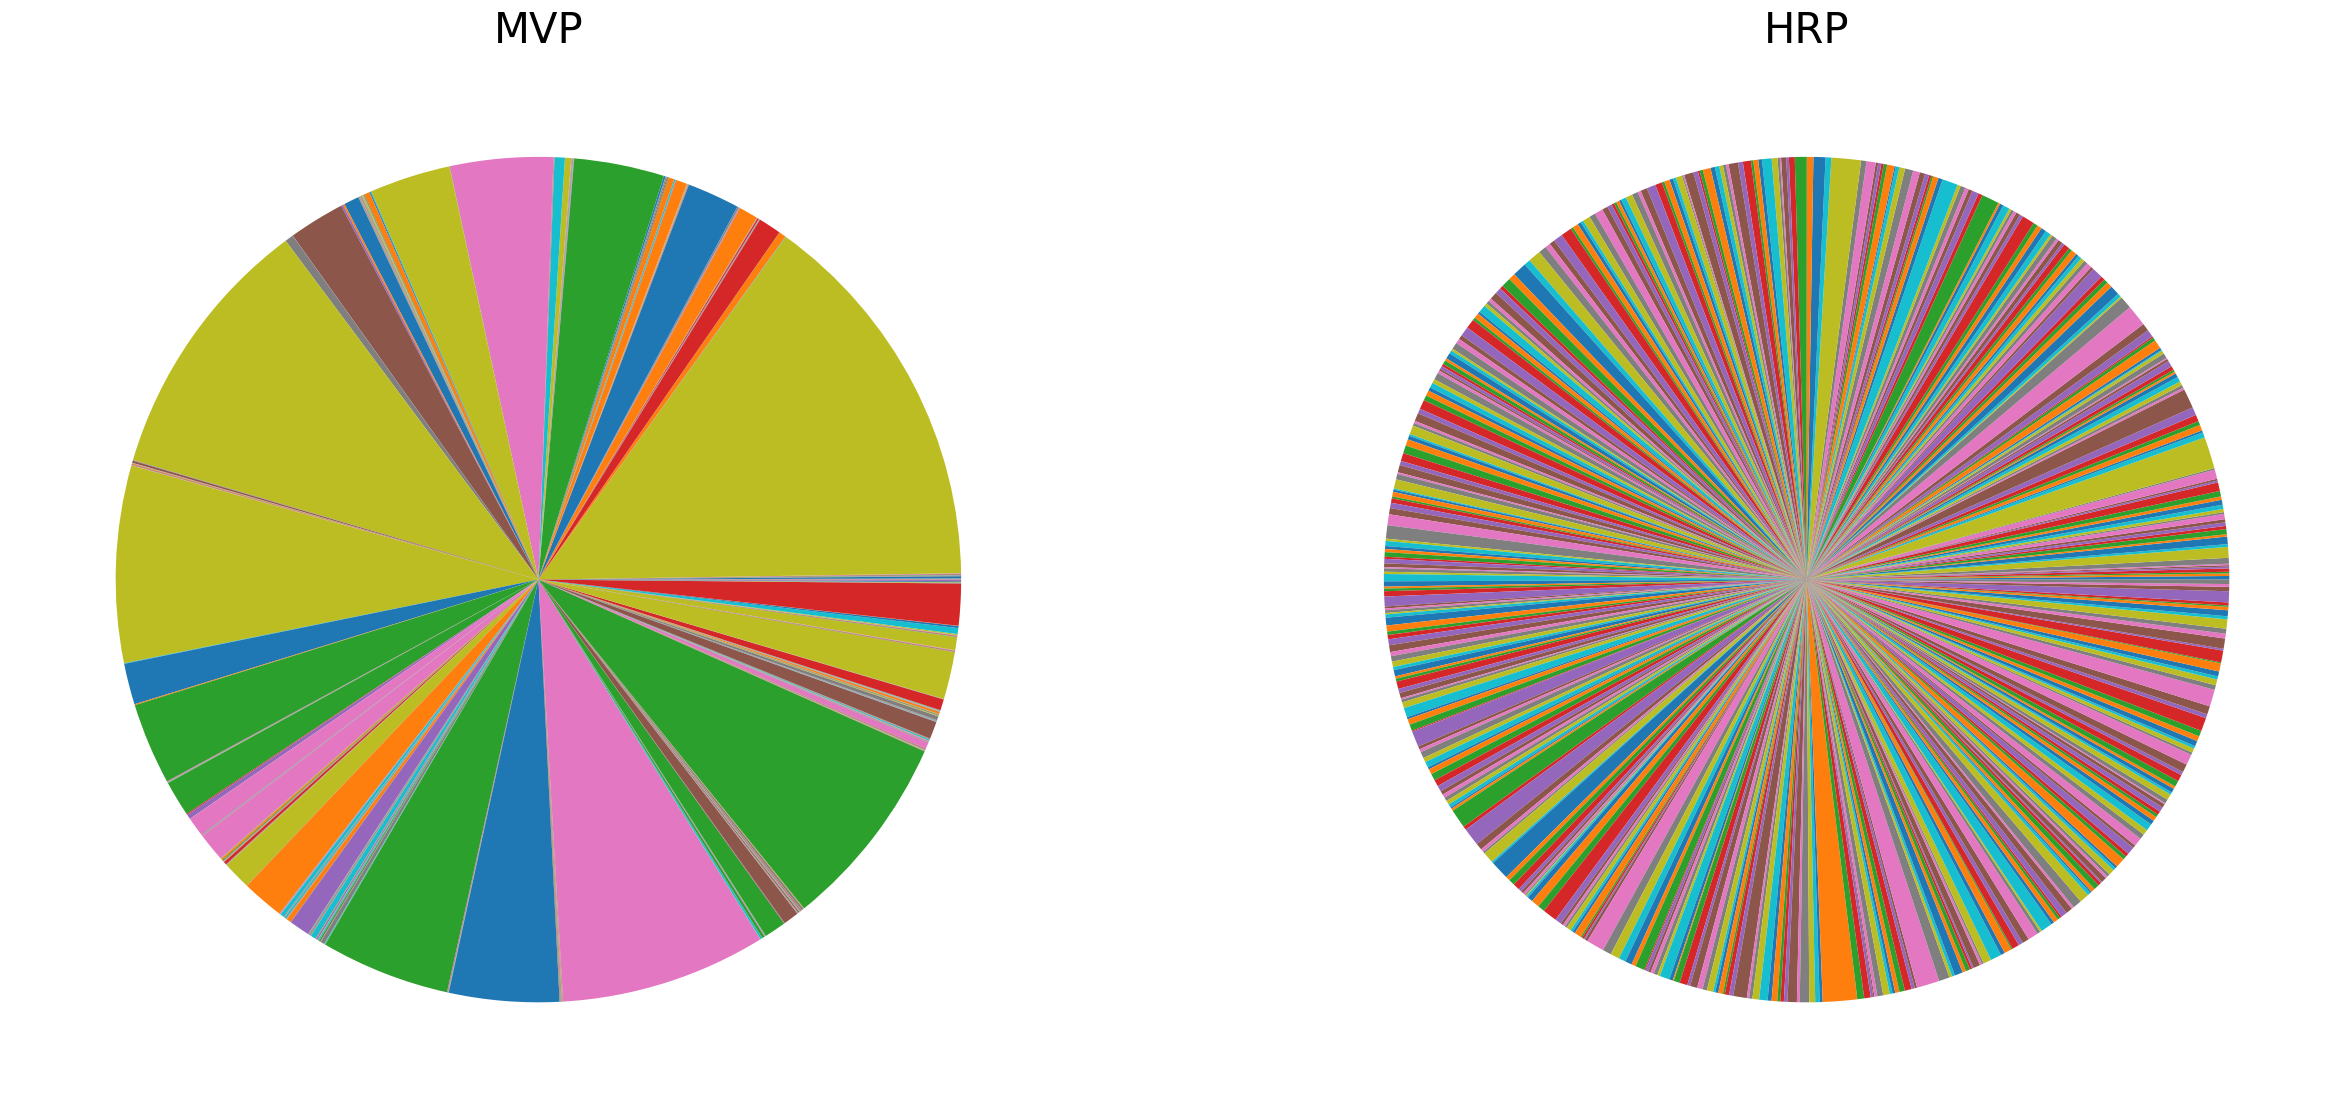

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

The first pie chart shown the asset allocation of MVP, followed by IVP and HRP. We clearly see more diversification in HRP as compared to MVP. On the
other hand, IVP evenly spreads weights through all assets, and it looks similar to
HRP. However, this method ignores the correlation structure between the instruments unlike HRP is included just for comparison purpose. Let us look at the backtesting results.

<a id='5'></a>
# 6. Backtesting-Out Of Sample 

In [23]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<Axes: title={'center': 'Out Of Sample Results'}, xlabel='Date'>

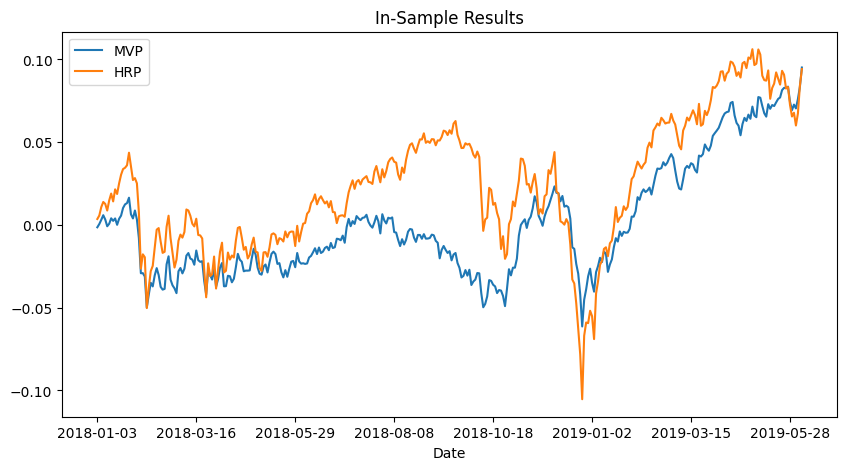

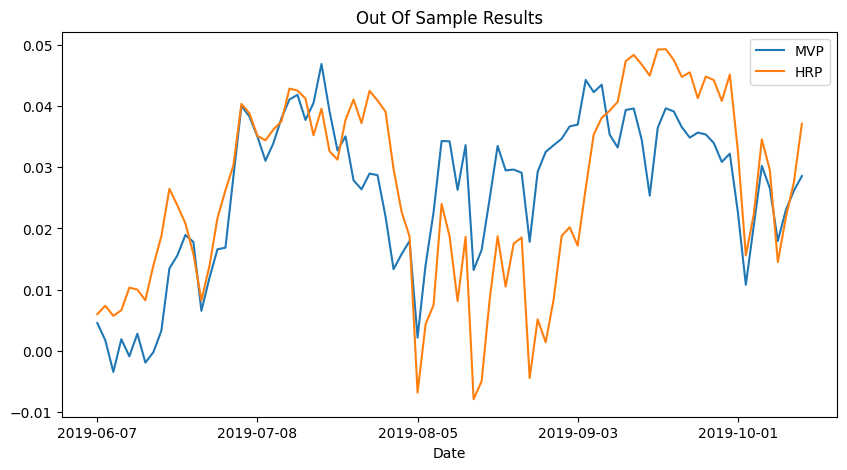

In [24]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

### In Sample and Out of Sample Results

In [25]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.085516,0.785019
HRP,0.126944,0.523599


In [26]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.102761,0.786621
HRP,0.125610,0.836159


While the in-sample performance of the Minimum Variance Portfolio (MVP) appears promising, the out-of-sample Sharpe ratio and overall returns are superior when using the hierarchical clustering approach. The enhanced diversification achieved by Hierarchical Risk Parity (HRP) across uncorrelated assets makes this methodology more resilient to market shocks.

**Conclusion**

The Markowitz minimum-variance portfolio tends to be less diversified, often concentrating investments in a limited number of stocks. In contrast, the hierarchical clustering-based allocation distributes capital more evenly across a broader range of assets, enhancing diversification and improving tail risk management.

Additionally, we implemented a backtesting framework to evaluate both in-sample and out-of-sample performance metrics—specifically returns and Sharpe ratios—for each portfolio strategy. This analysis helps identify the most effective allocation method. Among the approaches tested, hierarchical clustering consistently delivered the strongest out-of-sample performance.